In [1]:
SEED = 61

import numpy as np
import tensorflow as tf
import random as python_random
import os

def reset_seeds():
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    
import os
import re
import gc
import tensorflow_addons as tfa
import h5py
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk import tokenize

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from keras import backend as K
from keras import initializers,regularizers,constraints
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, Activation #, merge
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, Convolution1D, MaxPooling1D, MaxPooling2D
from keras.layers.core import RepeatVector #, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score

from tensorflow.python.keras.layers import Layer, InputSpec, Lambda

from transformers import BertTokenizer, BertForMaskedLM, BertModel

# from tensorflow.keras import Model
# from attention import Attention_input1, Attention_input2
# from keras.optimizers import SGD, RMSprop, Adagrad

In [2]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

def loadz(path):
    data = np.load(path)['arr_0']
    return data

In [3]:
def load_labels(path):
    data = read_hdf5(path)

    for x in data:
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
        
    return labels, text_labels, image_labels

def merge_mvsa(mvsa_single, mvsa_multiple):
    mvsa = np.concatenate((mvsa_single, mvsa_multiple), axis=0)
    return mvsa

def load_mvsa_feature(feature_name, merge=False):
    folder_path = os.path.join('../input/mvsa-features/', feature_name)
    single_file = 'mvsa-single-{}.npz'.format(feature_name)
    multiple_file = 'mvsa-multiple-{}.npz'.format(feature_name)
    mvsa_single = loadz(os.path.join(folder_path, single_file))
    mvsa_multiple = loadz(os.path.join(folder_path, multiple_file))
    
    if merge == True:
        return merge_mvsa(mvsa_single, mvsa_multiple)
    
    return mvsa_single, mvsa_multiple

In [4]:
# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    num_val = int(validation_split * data.shape[0])
    data_train = data[:-(num_val*2)]
    data_val = data[-(num_val*2):-(num_val)]
    data_test = data[-num_val:]
    return data_train, data_val, data_test

In [5]:
def weighted_average(weights, probs):
    '''
    weights: weights list (or array)
    probs: probability distributions array
    '''
    output_probs = []
    weighted_probs = [probs[i] * weights[i] for i in range(len(weights))]
    for i in range(len(probs[0])):
        sum_prob = np.zeros(len(probs[0][0]))
        for j in range(len(weights)):
            sum_prob = np.sum((sum_prob, weighted_probs[j][i]), axis=0)
        output_probs.append(sum_prob)
    return np.asarray(output_probs, dtype='float32')

In [6]:
def get_average_weights(*scores, inverse=False):
    # inverse weights in case of the smaller score value, the bigger weight
    weights = []
    for score in scores:
        weights.append(score/np.sum(scores))
    
    if inverse == True:
        inverse_weights = []
        inverse = [1/weight for weight in weights]
        for inv in inverse:
            inverse_weights.append(inv/np.sum(inverse))
        weights = inverse_weights

    return weights

In [7]:
def create_model_text(input_shape):
    f1_score = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')
    
    text_input = Input(shape=input_shape)
    reshape_text = Reshape((1, -1)) (text_input)
    lstm = LSTM(NUM_LSTM) (reshape_text)
    outputs = Dense(NUM_CLASSES, activation='softmax') (lstm)
    
    model = Model(text_input, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score]) # f1 #tf.keras.metrics.AUC()
    
    return model

In [8]:
def create_model_image(input_shape):
    f1_score = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')
    
    image_input = Input(shape=input_shape)
    outputs = Dense(NUM_CLASSES, activation='softmax') (image_input)
    
    model = Model(image_input, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score]) # f1 #tf.keras.metrics.AUC()
    return model

In [9]:
def run_and_evaluate_LF(name, X1, X2, y, verbose=0):
    ''' 
    X1: text input
    X2: image input
    y: labels
    verbose: 0 or 1 to print tracking on progress
    '''
    y = le.fit_transform(y)
    y = to_categorical(np.asarray(y))
    
    X1_train, X1_val, X1_test = split_data(X1, VALIDATION_SPLIT)
    X2_train, X2_val, X2_test = split_data(X2, VALIDATION_SPLIT)
    y_train, y_val, y_test = split_data(y, VALIDATION_SPLIT)
    
    model_text = create_model_text(X1_train.shape[1:])
    model_image = create_model_image(X2_train.shape[1:])

    early_stopping1 = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    early_stopping2 = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    checkpoint_text = ModelCheckpoint('./model_checkpoint/{}-text.h5'.format(name), save_best_only=True, verbose=verbose)
    checkpoint_image = ModelCheckpoint('./model_checkpoint/{}-image.h5'.format(name), save_best_only=True, verbose=verbose)
    
    history_text = model_text.fit(X1_train, y_train, validation_data=(X1_val, y_val), 
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose,
                        callbacks=[checkpoint_text, early_stopping1])
    
    history_image = model_image.fit(X2_train, y_train, validation_data=(X2_val, y_val), 
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose,
                        callbacks=[checkpoint_image, early_stopping2])
    
    best_val_loss_text = np.min(history_text.history['val_loss'])
    best_val_loss_image = np.min(history_image.history['val_loss'])

    weights = get_average_weights(best_val_loss_text, best_val_loss_image, inverse=True)

    model_text = load_model('./model_checkpoint/{}-text.h5'.format(name))
    model_image = load_model('./model_checkpoint/{}-image.h5'.format(name))

    y_pred_text = model_text.predict(X1_test)
    y_pred_image = model_image.predict(X2_test)
    
    y_pred = weighted_average(weights, np.asarray([y_pred_text, y_pred_image], dtype='float32'))
    
    best_epoch_text = np.argmin(history_text.history['val_loss'])
    best_epoch_image = np.argmin(history_image.history['val_loss'])

    print('Checkpoint of text model loaded at epoch:', best_epoch_text)
    print('Checkpoint of image model loaded at epoch:', best_epoch_image)

    return evaluate_LF(y_test, y_pred, verbose=verbose)

In [10]:
def evaluate_LF(y_true, y_pred, verbose=0):
    
    y_pred = le.inverse_transform(y_pred.argmax(axis=1))
    y_true = le.inverse_transform(y_true.argmax(axis=1))

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    if verbose == 1:
        print(classification_report(y_true, y_pred))
        matrix = confusion_matrix(y_true, y_pred,
                                  labels=list(le.classes_))
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=list(le.classes_))
        cm_disp.plot()
        plt.show()
        
    return acc, f1

In [11]:
def plot_metrics(history):
    fig = plt.figure(figsize=(20, 5))

    fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 3, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 3, 3)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('F1-SCORE')
    plt.ylabel('f1-score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    plt.show()

# Load data

In [12]:
## Choose best
# Load text feature
mvsa_single_bert_base, mvsa_multiple_bert_base = load_mvsa_feature('bert-base')
mvsa_single_pos_bow, mvsa_multiple_pos_bow = load_mvsa_feature('pos-bow')
# mvsa_single_pos_tfidf, mvsa_multiple_pos_tfidf = load_mvsa_feature('pos-tfidf')
# mvsa_single_ner_bow, mvsa_multiple_ner_bow = load_mvsa_feature('ner-bow')
# mvsa_single_ner_tfidf, mvsa_multiple_ner_tfidf = load_mvsa_feature('ner-tfidf')

## Load image feature
# mvsa_single_vgg16, mvsa_multiple_vgg16 = load_mvsa_feature('vgg16')
# mvsa_single_vgg19, mvsa_multiple_vgg19 = load_mvsa_feature('vgg19')
# mvsa_single_resnet50, mvsa_multiple_resnet50 = load_mvsa_feature('resnet50')
# mvsa_single_resnet101, mvsa_multiple_resnet101 = load_mvsa_feature('resnet101')
# mvsa_single_resnet152, mvsa_multiple_resnet152 = load_mvsa_feature('resnet152')
# mvsa_single_densenet121, mvsa_multiple_densenet121 = load_mvsa_feature('densenet121')
# mvsa_single_densenet169, mvsa_multiple_densenet169 = load_mvsa_feature('densenet169')
mvsa_single_densenet201, mvsa_multiple_densenet201 = load_mvsa_feature('densenet201')

In [13]:
mvsa_single_multimodal_labels, mvsa_single_text_labels, mvsa_single_image_labels = load_labels('../input/mvsa-features/labels/mvsa-single-labels.hdf5')
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, mvsa_multiple_image_labels = load_labels('../input/mvsa-features/labels/mvsa-multiple-labels.hdf5')

In [14]:
mvsa_single_text_features = np.concatenate((mvsa_single_bert_base, mvsa_single_pos_bow), axis=1)
mvsa_multiple_text_features = np.concatenate((mvsa_multiple_bert_base, mvsa_multiple_pos_bow), axis=1)

mvsa_single_image_features = mvsa_single_densenet201
mvsa_multiple_image_features = mvsa_multiple_densenet201

print('Text vector shape:', mvsa_single_text_features.shape[1:])
print('Image vector shape:', mvsa_single_image_features.shape[1:])

Text vector shape: (802,)
Image vector shape: (1920,)


In [15]:
le = preprocessing.LabelEncoder()
le.fit(mvsa_single_multimodal_labels)
NUM_CLASSES = len(le.classes_) # = 3

In [16]:
reset_seeds()
EPOCHS = 100
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1
EARLY_STOPPING = 100
NUM_LSTM = 128
DROPOUT_RATE = 0.1

2022-07-01 07:10:30.618568: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-01 07:10:31.398713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
27/27 [==============================] - 4s 36ms/step - loss: 0.8869 - accuracy: 0.5938 - f1_score: 0.3318 - val_loss: 0.7757 - val_accuracy: 0.6682 - val_f1_score: 0.4152

Epoch 00001: val_loss improved from inf to 0.77572, saving model to ./model_checkpoint/single-LF-text.h5
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.7569 - accuracy: 0.6714 - f1_score: 0.4719 - val_loss: 0.7463 - val_accuracy: 0.6798 - val_f1_score: 0.4908

Epoch 00002: val_loss improved from 0.77572 to 0.74633, saving model to ./model_checkpoint/single-LF-text.h5
Epoch 3/100
27/27 [==============================] - 0s 11ms/step - loss: 0.7208 - accuracy: 0.6957 - f1_score: 0.5497 - val_loss: 0.7998 - val_accuracy: 0.6473 - val_f1_score: 0.3775

Epoch 00003: val_loss did not improve from 0.74633
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6952 - accuracy: 0.7053 - f1_score: 0.5697 - val_loss: 0.7299 - val_accuracy: 0.6752 - val_f1_score: 0.5

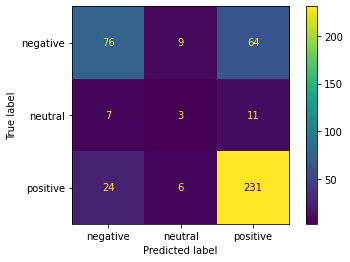

(0.7192575406032483, 0.5208036562203229)

In [17]:
run_and_evaluate_LF('single-LF', mvsa_single_text_features, mvsa_single_image_features, mvsa_single_multimodal_labels, verbose=1)

Epoch 1/100
103/103 [==============================] - 4s 15ms/step - loss: 0.7515 - accuracy: 0.6740 - f1_score: 0.3351 - val_loss: 0.6510 - val_accuracy: 0.7241 - val_f1_score: 0.3173

Epoch 00001: val_loss improved from inf to 0.65099, saving model to ./model_checkpoint/multiple-LF-text.h5
Epoch 2/100
103/103 [==============================] - 1s 8ms/step - loss: 0.6961 - accuracy: 0.6918 - f1_score: 0.4499 - val_loss: 0.6341 - val_accuracy: 0.7338 - val_f1_score: 0.3953

Epoch 00002: val_loss improved from 0.65099 to 0.63406, saving model to ./model_checkpoint/multiple-LF-text.h5
Epoch 3/100
103/103 [==============================] - 1s 8ms/step - loss: 0.6845 - accuracy: 0.6949 - f1_score: 0.4730 - val_loss: 0.6328 - val_accuracy: 0.7363 - val_f1_score: 0.4144

Epoch 00003: val_loss improved from 0.63406 to 0.63277, saving model to ./model_checkpoint/multiple-LF-text.h5
Epoch 4/100
103/103 [==============================] - 1s 8ms/step - loss: 0.6715 - accuracy: 0.6993 - f1_score:

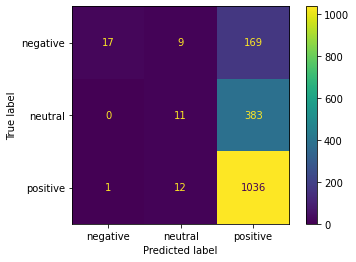

(0.6495726495726496, 0.33233632613529746)

In [18]:
run_and_evaluate_LF('multiple-LF', mvsa_multiple_text_features, mvsa_multiple_image_features, mvsa_multiple_multimodal_labels, verbose=1)